## Toliman Pupil Characterisation ✨

This notebook calculates the phase errors on the manufactured Toliman pupil.

Existing system aberrations are loaded and can be calculated using System_Aberrations.ipynb

In [26]:
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dLT

import jax.numpy as jnp
import numpy as np
import jax.scipy as jsp

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'upper' # true reading of array
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

data_dir = "/import/morgana2/gpir9156/toliman/"

### Simulation Parameters

In [27]:
# Source(s)
red_laser_wl =  635e-09  # for laser data
# green_laser_wl = 520e-09  # """ # starting with just red data for now
# thermal_wls = np.linspace(525, 625, 100)
src = dl.sources.PointSources(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))

# Aperture parameters
mask_path = "diffractive_pupil.npy"
mask = np.load(mask_path)
ratio = 1  # Ratio to scale the aperture by (e.g. 5 => 5-inch aperture becomes 1-inch aperture)
aperture_npix = mask.shape[0]  # Number of pixels across the aperture
aperture_diameter = 0.125 / ratio  # Clear aperture diameter (m)
secondary_diameter = 0.032 / ratio  # Secondary mirror diameter (m)
spider_width = 0.002 / ratio  # Spider width (m)

# Mask layer - at the moment I see the creation of this layer is wl dependent (no .apply() specs to handle this during prop?)
opd_req = red_laser_wl/2 # pi step (m)
mask *= opd_req
mask_layer = dl.BasisLayer(basis=np.array([mask]), coefficients=np.array([1]))

# Detector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1300#1350               # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

psf_npix = 256                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)             # half window sz of cropped data
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 


Non-uniform fiber intensity 

In [ ]:
intensity_dist = np.load(data_dir+"spider/11_11/2024/RHCP_intensity_img_80us_0gain_img_stack_batch_0.npy")
intensity_dist = np.flipud(intensity_dist)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(intensity_dist)

System aberrations

In [ ]:
# Optical system
os = dLT.TolimanOpticalSystem(        
        wf_npixels=aperture_npix,
        psf_npixels=psf_npix,
        oversample=1,
        psf_pixel_scale=psf_pixel_scale,
        mask=mask_layer,
        noll_indices=np.arange(2,11),
        )
# os = os.insert_layer(layer=)

# Combined system
model = dl.Telescope(os, ('source', src))

Display model

Telescope(
  optics=TolimanOpticalSystem(
    wf_npixels=2048,
    diameter=0.125,
    layers={
      'aperture':
      BasisOptic(
        basis=f32[9,2048,2048],
        coefficients=f32[9],
        as_phase=False,
        transmission=f32[2048,2048],
        normalise=True
      ),
      'pupil':
      BasisLayer(basis=f32[1,2048,2048], coefficients=f32[1], as_phase=False)
    },
    psf_npixels=256,
    oversample=1,
    psf_pixel_scale=0.3807965653791467
  ),
  source=PointSources(
    spectrum=Spectrum(wavelengths=f32[1], weights=f32[1]),
    position=f32[1,2],
    flux=f32[1]
  ),
  detector=None
)


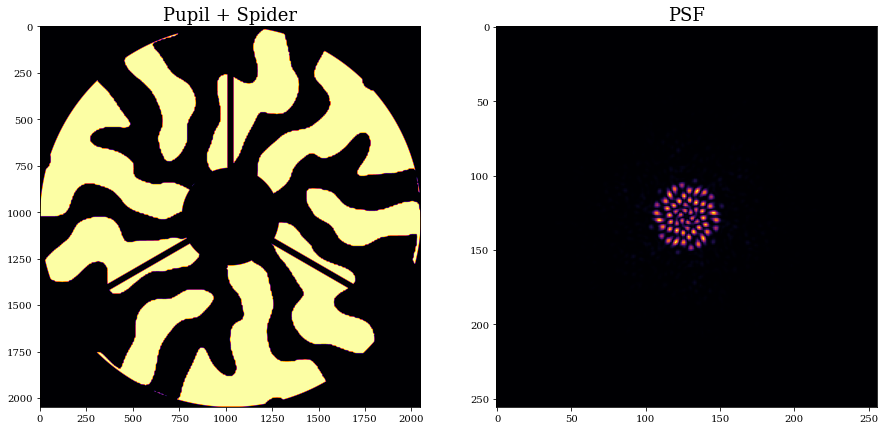

In [25]:
%matplotlib inline
psf = model.model()
pupil_basis = model.optics.pupil.eval_basis()
spider = model.optics.aperture.transmission
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(pupil_basis*spider)
plt.title("Pupil + Spider")
plt.subplot(1,2,2)
plt.imshow(psf)
plt.title("PSF")

print(model)

### Define Loss function
(and parameters we care to fit)

In [ ]:
params = [
    'aperture.coefficients',
    'source.position',
    'source.flux', 
    ]

learning_rate = 1e-9
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=1e-8),
            optax.adam(learning_rate=1e6),
              ]

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum()

    return loss


### Load in data
- Trying just red laser wl data for now